### Task 2: Data Visualisation

In [1]:
# import necessary library
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json
from pymongo import MongoClient
import folium 
from pprint import pprint

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'assignment'

1. **Streaming data visualization**</br>
a. For the incoming climate data plot the line graph of air temperature against
arrival time. You need to label some interesting points such as maximum
and minimum values.

<IPython.core.display.Javascript object>


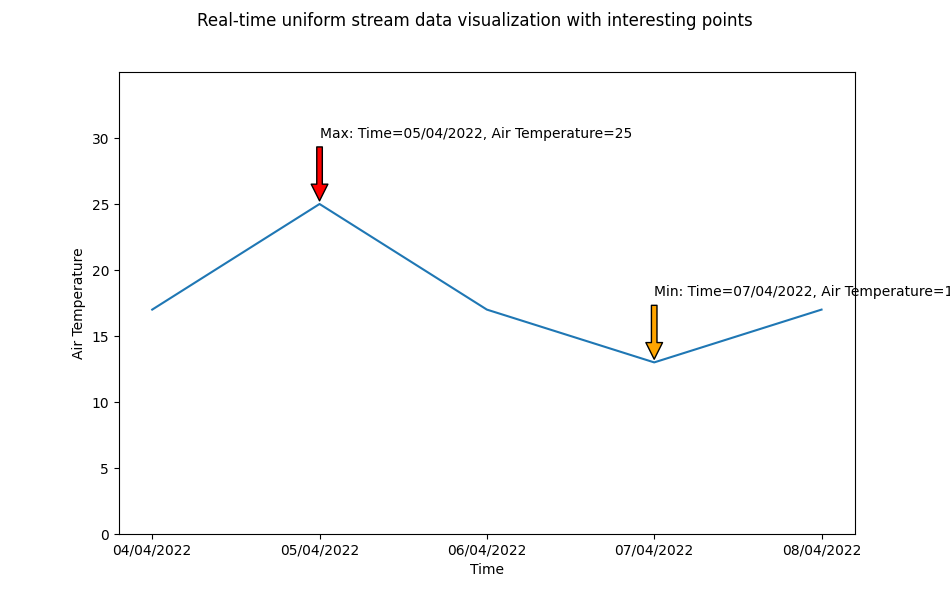

In [2]:
# Function to annotate the maximum air temperature
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Air Temperature={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)

# Function to annotate the minimum air temperature
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Air Temperature={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=20000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

# Function to plot the initial line chart
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Air Temperature')
        ax.set_ylim(0,35) 
        ax.set_yticks([0,5,10,15,20,25,30])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = json.loads(str(message.value.decode('utf-8')))
            if data["producer"] == "climate_producer":
                x.append(data["date"]) 
                y.append(int(data["air_temperature_celcius"]))
            # we start plotting only when we have 5 data points
            if len(y) >= 5:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Air Temperature')
                ax.set_ylim(0,35) 
                ax.set_yticks([0,5,10,15,20,25,30])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

2. **Static data visualization** </br>
Write python programs using pymongo to get the data from the MongoDB
collection(s) created in Part B, Task 1 and perform the following visualizations.</br>
a. Plot a bar chart to visualize the total number of fire records based on each
hour.

In [3]:
# connect to the assignment_db
client = MongoClient()
db = client.assignment_db

# Get the 2 collections for climate_streaming data and hotspot_streaming data
climate_streaming = db.climate_streaming
hotspot_streaming = db.hotspot_streaming

In [4]:
# Group the hotspot data based on the each hour
hour_group = [0] * 24
hotspots_arr = list(hotspot_streaming.find())
for hotspot in hotspots_arr:
    hour = hotspot["datetime"].hour
    hour_group[hour] += 1
print(hour_group)   

[0, 0, 17, 0, 0, 0, 0, 14, 0, 0, 0, 0, 18, 0, 0, 0, 0, 18, 0, 0, 0, 0, 16, 0]


<IPython.core.display.Javascript object>


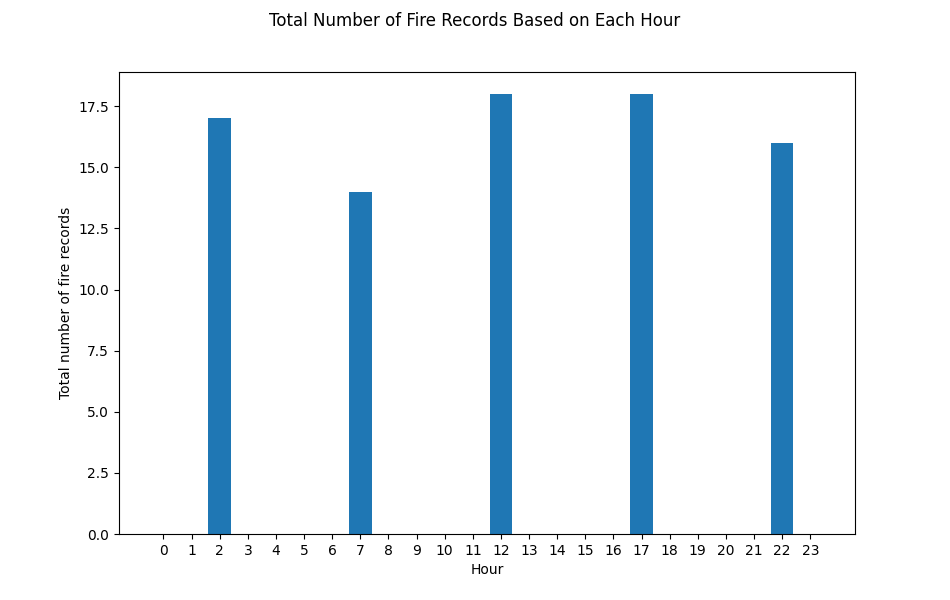

In [5]:
# Plot the bar chart
hours = list(range(24))
width = 9.5
height = 6
fig = plt.figure(figsize=(width,height))
fig.suptitle('Total Number of Fire Records Based on Each Hour') # giving figure a title
ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
ax.clear()
ax.set_xlabel('Hour')
ax.set_ylabel('Total number of fire records')
ax.set_xticks(hours)
ax.bar(hours,hour_group)
fig.show() # displaying the figure
fig.canvas.draw() # drawing on the canvas

b. In a map visualize fire locations as markers. Use a ‘blue’ marker if the cause
of the fire was ‘natural’. Otherwise, use a ‘red’ marker. Display detailed
information such as air temperature, surface temperature, relative humidity, and confidence with the marker tooltip. See the example below. You can use Folium for map visualization.

In [6]:
# Join the hotspot_streaming data together with the climate_streaming data based on the common attribute "date"
group_climate_hotspot = hotspot_streaming.aggregate([
    {
        "$lookup": {
            "from": "climate_streaming",
            "localField": "date",
            "foreignField": "date",
            "as": "climate_data"
        }
    },
    
    {
        "$project": {
            "latitude": 1, 
            "longitude": 1,
            "confidence": 1,
            "surface_temperature_celcius":1,
            "cause_of_fire": 1,
            "climate_data.air_temperature_celcius":1,
            "climate_data.relative_humidity":1
        }
    }
])

# Group the joined data based on the cause of fire
natural_fire_loc = [] # array containing data of natural cause fire
other_fire_loc = [] # array containing data of other cause fire
group_climate_hotspot = list(group_climate_hotspot)

# Loop the each joined data to group them based on the cause of fire
for hs in group_climate_hotspot:
    if hs["cause_of_fire"] == "natural":
        natural_fire_loc.append(hs)
    elif hs["cause_of_fire"] == "other":
        other_fire_loc.append(hs)
        
pprint("Total Natural Fire: " + str(len(natural_fire_loc)))
pprint("Total Other Causes Fire: " + str(len(other_fire_loc)))

'Total Natural Fire: 7'
'Total Other Causes Fire: 76'


In [7]:
fomap = folium.Map(location=[-37.812015244225677, 144.951471202974],zoom_start=10)

In [8]:
# Add a blue marker to the map for each natural cause fire
for nat in natural_fire_loc:
    # Get the datas that need to be shown on the tooltip
    surface_temp = nat["surface_temperature_celcius"]
    confidence = nat["confidence"]
    air_temp = nat["climate_data"][0]["air_temperature_celcius"]
    humidity = nat["climate_data"][0]["relative_humidity"]
    
    tip = '<ul><li>Surface Temp: {surface_temp}</li> <li>Confidence: {confidence}</li>\
            <li>Air Temp: {air_temp}</li> <li>Relative Humidity: {humidity}</li>'.format(
        surface_temp=surface_temp, 
        confidence=confidence, 
        air_temp=air_temp, 
        humidity=humidity) # format the tooptip 
    
    folium.Marker(location=(float(nat["latitude"]), float(nat["longitude"])), 
                  icon=folium.Icon(color='blue'), tooltip=tip).add_to(fomap)


# Add a red marker to the map for each other cause fire
for oth in other_fire_loc:
    # Get the datas that need to be shown on the tooltip
    surface_temp = oth["surface_temperature_celcius"]
    confidence = oth["confidence"]
    air_temp = oth["climate_data"][0]["air_temperature_celcius"]
    humidity = oth["climate_data"][0]["relative_humidity"]
    
    tip = '<ul><li>Surface Temp: {surface_temp}</li> <li>Confidence: {confidence}</li>\
            <li>Air Temp: {air_temp}</li> <li>Relative Humidity: {humidity}</li>'.format(
        surface_temp=surface_temp, 
        confidence=confidence, 
        air_temp=air_temp, 
        humidity=humidity) # format the tooltip
    
    folium.Marker(location=(float(oth["latitude"]), float(oth["longitude"])), 
                  icon=folium.Icon(color='red'), tooltip=tip).add_to(fomap)

In [9]:
fomap # print out the map

#### Reference
- Writing tooltip refer from </br>https://peps.python.org/pep-0498/#:~:text=In%20Python%20source%20code%2C%20an,are%20replaced%20with%20their%20values.

- Change marker color refer from </br>https://www.programcreek.com/python/example/91851/folium.Marker